# Importing Libraries

In [5321]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
%matplotlib inline

# Reading data

In [5322]:
df = pd.read_csv("train.csv", parse_dates=['Date_of_Journey'], dayfirst= True)

In [5323]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,Airline C,2019-06-12,Delhi,Cochin,DEL → MAA → COK,20:40,6/13/2020 9:25,12h 45m,1 stop,No info,7480
1,Airline A,2019-06-18,Banglore,Delhi,BLR → DEL,18:55,22:00,3h 5m,non-stop,No info,8016
2,Airline C,2019-05-18,Delhi,Cochin,DEL → BOM → COK,3:50,19:15,15h 25m,1 stop,No info,8879
3,Airline A,2019-05-06,Kolkata,Banglore,CCU → BOM → BLR,20:00,5/7/2020 8:15,12h 15m,1 stop,In-flight meal not included,9663
4,Airline A,2019-05-09,Kolkata,Banglore,CCU → BOM → BLR,6:30,12:00,5h 30m,1 stop,In-flight meal not included,9663


# Data Cleaning

In [5324]:
#Renaming columns for ease of use
df.rename(columns = {'Additional_Info':'Info', 'Date_of_Journey': 'Start_Date'}, inplace = True)

In [5325]:
#Checking dimension of datatset
df.shape

(8012, 11)

In [5326]:
#Checking for duplicate values
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows: {}".format(duplicate_rows_df.shape))
duplicate_rows_df.head()

number of duplicate rows: (117, 11)


,Airline,Start_Date,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Info,Price
1048,Airline A,2019-06-15,Delhi,Cochin,DEL → JAI → BOM → COK,5:30,6/16/2020 4:25,22h 55m,2 stops,In-flight meal not included,10368
1331,Airline A,2019-06-12,Delhi,Cochin,DEL → NAG → BOM → COK,14:35,6/13/2020 12:35,22h,2 stops,In-flight meal not included,10919
1421,Airline A,2019-06-15,Delhi,Cochin,DEL → JAI → BOM → COK,5:30,6/16/2020 4:25,22h 55m,2 stops,No info,13014
1909,Airline A,2019-03-21,Delhi,Cochin,DEL → AMD → BOM → COK,19:10,3/23/2020 4:25,33h 15m,2 stops,In-flight meal not included,8834
2000,Airline C,2019-05-09,Delhi,Cochin,DEL → GOI → BOM → COK,22:00,5/10/2020 19:15,21h 15m,2 stops,No info,10441


**These duplicate rows should not be deleted as different airlines can go through the same route or have different duration**

In [5327]:
#Basic column information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8012 entries, 0 to 8011
Data columns (total 11 columns):
Airline         8012 non-null object
Start_Date      8012 non-null datetime64[ns]
Source          8012 non-null object
Destination     8012 non-null object
Route           8011 non-null object
Dep_Time        8012 non-null object
Arrival_Time    8012 non-null object
Duration        8012 non-null object
Total_Stops     8011 non-null object
Info            8012 non-null object
Price           8012 non-null int64
dtypes: datetime64[ns](1), int64(1), object(9)
memory usage: 688.7+ KB


In [5328]:
#Only single null value in the Total_Stops column. Therefore, checking the row
df[df.isnull().any(axis=1)]

,Airline,Start_Date,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Info,Price
1807,Airline C,2019-05-06,Delhi,Cochin,NaN,9:45,5/7/2020 9:25,23h 40m,NaN,No info,7480


In [5329]:
#Same row has null value for Route
#Checking similar rows to find replacement if possible
AC = df[df['Airline']=='Airline C'][df['Source']=='Delhi']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


Airline C: if Source is Delhi, then Destination is Cochin (helps us know the trend)
17 different routes(need to find the trend according to different dates)
only 4 Total_Stops (find trend according to date and routes)

In [5330]:
AC[AC['Duration']=='23h 40m'].sort_values(by= 'Price')

,Airline,Start_Date,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Info,Price
6523,Airline C,2019-04-01,Delhi,Cochin,DEL → MAA → COK,9:45,4/2/2020 9:25,23h 40m,1 stop,No info,5117
6066,Airline C,2019-03-27,Delhi,Cochin,DEL → HYD → MAA → COK,9:45,3/28/2020 9:25,23h 40m,2 stops,No info,7090
1807,Airline C,2019-05-06,Delhi,Cochin,NaN,9:45,5/7/2020 9:25,23h 40m,NaN,No info,7480
679,Airline C,2019-05-15,Delhi,Cochin,DEL → MAA → COK,9:45,5/16/2020 9:25,23h 40m,1 stop,No info,7480
1224,Airline C,2019-06-12,Delhi,Cochin,DEL → MAA → COK,9:45,6/13/2020 9:25,23h 40m,1 stop,No info,7480
7269,Airline C,2019-05-24,Delhi,Cochin,DEL → MAA → COK,9:45,5/25/2020 9:25,23h 40m,1 stop,No info,7480
4113,Airline C,2019-03-21,Delhi,Cochin,DEL → MAA → COK,9:45,3/22/2020 9:25,23h 40m,1 stop,No info,7532
896,Airline C,2019-06-06,Delhi,Cochin,DEL → MAA → COK,9:45,6/7/2020 9:25,23h 40m,1 stop,No info,7952
3844,Airline C,2019-03-21,Delhi,Cochin,DEL → HYD → MAA → COK,9:45,3/22/2020 9:25,23h 40m,2 stops,No info,8140
1755,Airline C,2019-06-01,Delhi,Cochin,DEL → MAA → COK,9:45,6/2/2020 9:25,23h 40m,1 stop,No info,8372


In [5331]:
df[df['Price']== 7480]

,Airline,Start_Date,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Info,Price
0,Airline C,2019-06-12,Delhi,Cochin,DEL → MAA → COK,20:40,6/13/2020 9:25,12h 45m,1 stop,No info,7480
325,Airline C,2019-06-03,Delhi,Cochin,DEL → MAA → COK,17:20,6/4/2020 9:25,16h 5m,1 stop,No info,7480
353,Airline C,2019-06-15,Delhi,Cochin,DEL → MAA → COK,12:30,6/16/2020 9:25,20h 55m,1 stop,No info,7480
535,Airline C,2019-06-01,Delhi,Cochin,DEL → TRV → COK,5:15,6/2/2020 6:50,25h 35m,1 stop,No info,7480
679,Airline C,2019-05-15,Delhi,Cochin,DEL → MAA → COK,9:45,5/16/2020 9:25,23h 40m,1 stop,No info,7480
965,Airline C,2019-05-21,Delhi,Cochin,DEL → MAA → COK,12:30,5/22/2020 9:25,20h 55m,1 stop,No info,7480
1115,Airline C,2019-05-21,Delhi,Cochin,DEL → MAA → COK,6:05,5/22/2020 9:25,27h 20m,1 stop,No info,7480
1224,Airline C,2019-06-12,Delhi,Cochin,DEL → MAA → COK,9:45,6/13/2020 9:25,23h 40m,1 stop,No info,7480
1423,Airline C,2019-06-03,Delhi,Cochin,DEL → MAA → COK,20:40,6/4/2020 9:25,12h 45m,1 stop,No info,7480
1807,Airline C,2019-05-06,Delhi,Cochin,NaN,9:45,5/7/2020 9:25,23h 40m,NaN,No info,7480


The time duration is 24h 30m and only 2 routes show that time duration DEL - MAA - COK and DEL - HYD - MAA - COK
Sorting the values by price: 3 other rows with same price and time show the same route.
Also, sorting Airline C according to price 7480, only this route has that price.
Therefore, we can safely replace the null values with this value.

In [5332]:
#Replacing the null values
df['Total_Stops'].fillna('1 stop', inplace = True)
df['Route'].fillna('DEL → MAA → COK', inplace = True)

# Data Cleaning - Info

In [5333]:
df.Info.value_counts()

No info                         6251
In-flight meal not included     1492
No check-in baggage included     249
1 Long layover                     9
Business class                     3
No Info                            3
Change airports                    2
1 Short layover                    1
2 Long layover                     1
Red-eye flight                     1
Name: Info, dtype: int64

In [5334]:
#We see 2 different string values for the same info. Therefore, replacing 'No Info' with 'No info' as both mean the same.
df.Info.replace(to_replace = 'No Info', value = 'No info', inplace = True)

In [5335]:
df.Info.value_counts()

No info                         6254
In-flight meal not included     1492
No check-in baggage included     249
1 Long layover                     9
Business class                     3
Change airports                    2
1 Short layover                    1
2 Long layover                     1
Red-eye flight                     1
Name: Info, dtype: int64

In [5336]:
df[df['Info']=='Red-eye flight']

,Airline,Start_Date,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Info,Price
1853,Airline G,2019-03-01,Banglore,New Delhi,BLR → DEL,23:25,3/2/2020 2:10,2h 45m,non-stop,Red-eye flight,10873


**A red-eye flight is the one that is scheduled to depart at night and arrive the next morning || 
Only 1 row has that information**

In [5337]:
#Checking other flight Info column that leave around the same time
df[df['Dep_Time']>='23:25'].sort_values('Price', ascending = False).head(25)

,Airline,Start_Date,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Info,Price
1870,Airline J,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,5:45,11:25,5h 40m,1 stop,Business class,79512
3343,Airline J,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,5:45,12:25,6h 40m,1 stop,Business class,62427
6894,Airline J,2019-03-01,Banglore,New Delhi,BLR → MAA → DEL,9:45,14:25,4h 40m,1 stop,Business class,57209
5734,Airline J,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,5:45,10:45,5h,1 stop,No info,52229
7237,Airline C,2019-03-01,Banglore,New Delhi,BLR → BOM → NAG → DEL,8:50,3/2/2020 10:35,25h 45m,2 stops,No info,31783
761,Airline C,2019-03-01,Delhi,Cochin,DEL → BOM → COK,4:00,3/2/2020 7:40,27h 40m,1 stop,No info,28322
4779,Airline A,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,5:45,19:10,13h 25m,1 stop,No info,27992
7288,Airline A,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,7:00,20:20,13h 20m,1 stop,No info,27992
6377,Airline A,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,5:45,20:20,14h 35m,1 stop,No info,27992
6558,Airline A,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,5:45,21:20,15h 35m,1 stop,No info,27992


Turns out that it is the only flight in the high-priced range during that time that has no stops and has the minimum time duration || 
We can replace 'Red-eye flight' with 'No info' but it might behave as an outlier since it has minimum duration, no stops and the highest price || 
a similar flight at index 7520 has a lower price || 
Airline B is costlier than Airline G || 
Therefore, dropping that row

In [5338]:
#Dropping the row with Info = Red-eye flight
df.drop(index = 1853, inplace = True)

In [5339]:
pd.pivot_table(df, index = 'Airline', values = 'Price', aggfunc = 'mean').sort_values('Price', ascending = False)

,Price
Airline,
Airline J,58358.666667
Airline A,11609.556751
Airline I,11431.333333
Airline D,10891.398455
Airline C,9552.735820
Airline K,8962.333333
Airline F,7683.708333
Airline H,5925.883562
Airline B,5679.238710


In [5340]:
#Checking the row with 1 Long layover
df[df['Info'] == '1 Long layover']

,Airline,Start_Date,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Info,Price
582,Airline A,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,22:50,3/2/2020 11:25,12h 35m,1 stop,1 Long layover,31825
917,Airline C,2019-03-01,Banglore,New Delhi,BLR → AMD → DEL,0:30,23:55,23h 25m,1 stop,1 Long layover,12599
1916,Airline A,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,22:50,3/2/2020 9:30,10h 40m,1 stop,1 Long layover,31825
2508,Airline A,2019-06-24,Delhi,Cochin,DEL → BOM → COK,8:00,19:00,11h,1 stop,1 Long layover,18581
2822,Airline C,2019-03-01,Banglore,New Delhi,BLR → MAA → DEL,11:50,3/2/2020 13:00,25h 10m,1 stop,1 Long layover,15434
3101,Airline C,2019-03-01,Banglore,New Delhi,BLR → AMD → DEL,0:30,20:30,20h,1 stop,1 Long layover,14752
4635,Airline A,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,11:40,21:20,9h 40m,1 stop,1 Long layover,27992
5511,Airline A,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,18:40,3/2/2020 9:30,14h 50m,1 stop,1 Long layover,31825
6164,Airline A,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,16:55,3/2/2020 10:25,17h 30m,1 stop,1 Long layover,25735


In [5341]:
#Checking the row with 1 Short layover
df[df['Info'] == '1 Short layover']

,Airline,Start_Date,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Info,Price
1079,Airline C,2019-03-01,Banglore,New Delhi,BLR → BOM → BHO → DEL,8:50,23:25,14h 35m,2 stops,1 Short layover,26743


In [5342]:
df[df['Price']>= 26000].sort_values('Price')

,Airline,Start_Date,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Info,Price
5401,Airline C,2019-03-01,Banglore,New Delhi,BLR → BOM → BHO → DEL,6:45,3/2/2020 9:25,26h 40m,2 stops,2 Long layover,26480
1079,Airline C,2019-03-01,Banglore,New Delhi,BLR → BOM → BHO → DEL,8:50,23:25,14h 35m,2 stops,1 Short layover,26743
7671,Airline A,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,8:55,18:25,9h 30m,1 stop,No info,26890
4519,Airline A,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,7:00,12:25,5h 25m,1 stop,No info,26890
5293,Airline A,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,11:40,3/2/2020 0:45,13h 5m,1 stop,No info,26890
3980,Airline A,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,8:00,18:25,10h 25m,1 stop,No info,26890
6116,Airline A,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,16:55,3/2/2020 8:15,15h 20m,1 stop,No info,26890
6315,Airline A,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,7:00,18:25,11h 25m,1 stop,No info,26890
6322,Airline A,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,22:50,3/2/2020 7:40,8h 50m,1 stop,No info,26890
2270,Airline A,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,16:55,3/2/2020 0:45,7h 50m,1 stop,No info,26890


In [5343]:
df[df['Info'] == 'Change airports']

,Airline,Start_Date,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Info,Price
2367,Airline C,2019-03-01,Banglore,New Delhi,BLR → COK → DEL,22:00,3/2/2020 23:20,25h 20m,1 stop,Change airports,14305
4385,Airline C,2019-03-01,Banglore,New Delhi,BLR → CCU → BBI → DEL,5:50,16:20,10h 30m,2 stops,Change airports,15119


**We observe that the information regarding layovers doesn't affect the prices throughout and are also a few in number || Therefore, we can replace the values describing about layovers with 'No info'**

**Also, the rows for which Info = 'Change airports' doesn't affect the price much || Therefore, can be replaced with 'No info'**

**Generally, Shouldn't replace 'Business class' value with 'No info' as it is the only indicator that the Price has to be exorbitantly high || But since only Airline J had specified Business class, it might create a bias in the dataset. Hence, should be clubbed along with No info**

**If we observe closely then these values describing about layovers and 'Change airports' belong to the same date || Which indicates that this information is not much helpful when spanned over to other dates || Therefore, can be considered as 'No info'**

In [5344]:
df["Info"].replace({'1 Short layover':'No info','2 Long layover':'No info', 'Change airports': 'No info', '1 Long layover': 'No info', 'Business class': 'No info' }, inplace=True)

In [5345]:
df.Info.value_counts()

No info                         6270
In-flight meal not included     1492
No check-in baggage included     249
Name: Info, dtype: int64

# Data Cleaning - Total_Stops

In [5346]:
df.Total_Stops.unique()

array(['1 stop', 'non-stop', '2 stops', '3 stops'], dtype=object)

In [5347]:
#Replacing long string values with numbers for ease of use
def stops(x):
    if(x=='non-stop'):
        x=str(0)
    else:
        x.strip()
        stps=x.split(' ')[0]
        x=stps
    return x
df['Total_Stops']=df['Total_Stops'].apply(stops)

# Data Cleaning - Duration

In [5348]:
#Converting hours into minutes
df['Duration'] = df['Duration'].str.replace("h", '*60').str.replace(' ','+').str.replace('m','*1').apply(eval)

In [5349]:
df.head()

,Airline,Start_Date,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Info,Price
0,Airline C,2019-06-12,Delhi,Cochin,DEL → MAA → COK,20:40,6/13/2020 9:25,765,1,No info,7480
1,Airline A,2019-06-18,Banglore,Delhi,BLR → DEL,18:55,22:00,185,0,No info,8016
2,Airline C,2019-05-18,Delhi,Cochin,DEL → BOM → COK,3:50,19:15,925,1,No info,8879
3,Airline A,2019-05-06,Kolkata,Banglore,CCU → BOM → BLR,20:00,5/7/2020 8:15,735,1,In-flight meal not included,9663
4,Airline A,2019-05-09,Kolkata,Banglore,CCU → BOM → BLR,6:30,12:00,330,1,In-flight meal not included,9663


# Data Cleaning - Arrival_Time

In [5350]:
#Departure
df["Dep_hour"] = pd.to_datetime(df["Dep_Time"]).dt.hour
df["Dep_min"] = pd.to_datetime(df["Dep_Time"]).dt.minute
df.drop(["Dep_Time"], axis = 1, inplace = True)
#Arrival
df["Arrival_hour"] = pd.to_datetime(df.Arrival_Time).dt.hour
df["Arrival_min"] = pd.to_datetime(df.Arrival_Time).dt.minute
df.drop(["Arrival_Time"], axis = 1, inplace = True)

In [5351]:
df.head()

,Airline,Start_Date,Source,Destination,Route,Duration,Total_Stops,Info,Price,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,Airline C,2019-06-12,Delhi,Cochin,DEL → MAA → COK,765,1,No info,7480,20,40,9,25
1,Airline A,2019-06-18,Banglore,Delhi,BLR → DEL,185,0,No info,8016,18,55,22,0
2,Airline C,2019-05-18,Delhi,Cochin,DEL → BOM → COK,925,1,No info,8879,3,50,19,15
3,Airline A,2019-05-06,Kolkata,Banglore,CCU → BOM → BLR,735,1,In-flight meal not included,9663,20,0,8,15
4,Airline A,2019-05-09,Kolkata,Banglore,CCU → BOM → BLR,330,1,In-flight meal not included,9663,6,30,12,0


In [5352]:
df["Journey_month"] = df.Start_Date.dt.month
df['Dep_Date'] = df.Start_Date.dt.day
df.drop('Start_Date', axis = 1, inplace = True)

In [5353]:
df.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Info,Price,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Journey_month,Dep_Date
0,Airline C,Delhi,Cochin,DEL → MAA → COK,765,1,No info,7480,20,40,9,25,6,12
1,Airline A,Banglore,Delhi,BLR → DEL,185,0,No info,8016,18,55,22,0,6,18
2,Airline C,Delhi,Cochin,DEL → BOM → COK,925,1,No info,8879,3,50,19,15,5,18
3,Airline A,Kolkata,Banglore,CCU → BOM → BLR,735,1,In-flight meal not included,9663,20,0,8,15,5,6
4,Airline A,Kolkata,Banglore,CCU → BOM → BLR,330,1,In-flight meal not included,9663,6,30,12,0,5,9


# Data Cleaning - Route

In [5354]:
df['Airport_1'] = df['Route'].str.split('→').str[0]
df['Airport_2'] = df['Route'].str.split('→').str[1]
df['Airport_3'] = df['Route'].str.split('→').str[2]
df['Airport_4'] = df['Route'].str.split('→').str[3]
df['Airport_5'] = df['Route'].str.split('→').str[4]

df['Airport_1'].fillna('None', inplace = True)
df['Airport_2'].fillna('None', inplace = True)
df['Airport_3'].fillna('None', inplace = True)
df['Airport_4'].fillna('None', inplace = True)
df['Airport_5'].fillna('None', inplace = True)
df.drop('Route', axis = 1, inplace = True)

In [5355]:
df.head()

,Airline,Source,Destination,Duration,Total_Stops,Info,Price,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Journey_month,Dep_Date,Airport_1,Airport_2,Airport_3,Airport_4,Airport_5
0,Airline C,Delhi,Cochin,765,1,No info,7480,20,40,9,25,6,12,DEL,MAA,COK,None,None
1,Airline A,Banglore,Delhi,185,0,No info,8016,18,55,22,0,6,18,BLR,DEL,None,None,None
2,Airline C,Delhi,Cochin,925,1,No info,8879,3,50,19,15,5,18,DEL,BOM,COK,None,None
3,Airline A,Kolkata,Banglore,735,1,In-flight meal not included,9663,20,0,8,15,5,6,CCU,BOM,BLR,None,None
4,Airline A,Kolkata,Banglore,330,1,In-flight meal not included,9663,6,30,12,0,5,9,CCU,BOM,BLR,None,None


In [5356]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8011 entries, 0 to 8011
Data columns (total 18 columns):
Airline          8011 non-null object
Source           8011 non-null object
Destination      8011 non-null object
Duration         8011 non-null int64
Total_Stops      8011 non-null object
Info             8011 non-null object
Price            8011 non-null int64
Dep_hour         8011 non-null int64
Dep_min          8011 non-null int64
Arrival_hour     8011 non-null int64
Arrival_min      8011 non-null int64
Journey_month    8011 non-null int64
Dep_Date         8011 non-null int64
Airport_1        8011 non-null object
Airport_2        8011 non-null object
Airport_3        8011 non-null object
Airport_4        8011 non-null object
Airport_5        8011 non-null object
dtypes: int64(8), object(10)
memory usage: 1.2+ MB


# EDA

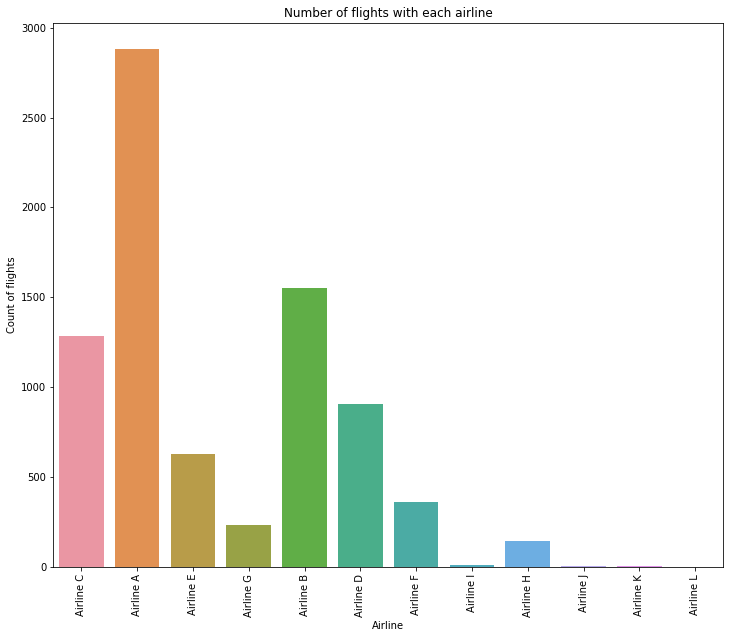

In [5357]:
#Number of flights with each airlne
plt.figure(figsize = (12, 10))
plt.title('Number of flights with each airline')
ax=sns.countplot(x = df['Airline'])
plt.xlabel('Airline')
plt.ylabel('Count of flights')
plt.xticks(rotation = 90)
plt.show()

**A > B > C > D > E > F > G > H > I > J > K > L**

**Negligible number of flights for airline J, K, and L || But dropping these would not help us generalize the results for the future datasets**

In [5358]:
df.drop(df[df['Airline'] == 'Airline J'].index, inplace = True)
df.drop(df[df['Airline'] == 'Airline K'].index, inplace = True)
df.drop(df[df['Airline'] == 'Airline L'].index, inplace = True)

Text(0, 0.5, 'Price of ticket')

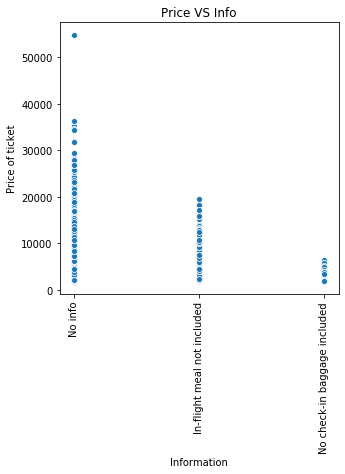

In [5359]:
#Price VS Info
plt.figure(figsize = (5,5))
plt.title('Price VS Info')
sns.scatterplot(df['Info'], df['Price'])
plt.xticks(rotation = 90)
plt.xlabel('Information')
plt.ylabel('Price of ticket')

**As expected the prices for business class are exorbitantly high as compared to the rest of the dataset || The dataset contains data from almost the same group of pricing**

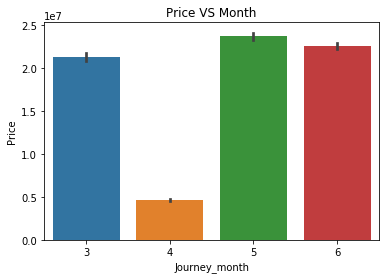

In [5360]:
#Which month has the highest flight prices?
sns.barplot(x='Journey_month', y='Price', data=df,estimator=sum)
plt.title('Price VS Month')
plt.show()

**May > June > March > April**

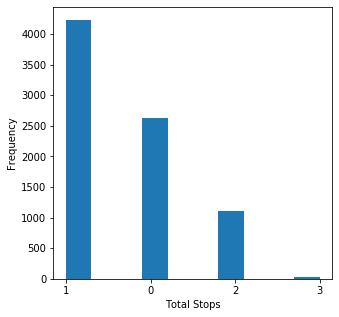

In [5361]:
#Frequency of flight as per months
plt.figure(figsize = (5,5))
plt.hist(df.Total_Stops)
plt.xlabel('Total Stops')
plt.ylabel('Frequency')
plt.show()

**Maximum flights have 1 stop airport || Followed by **

# One-Hot Encoding - Airline, Source, Destination, Info, Total_Stops, Airports

In [5362]:
#For Airline
airline_dummies = pd.get_dummies(df.Airline)
airline_dummies

,Airline A,Airline B,Airline C,Airline D,Airline E,Airline F,Airline G,Airline H,Airline I
0,0,0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
8007,1,0,0,0,0,0,0,0,0
8008,0,0,1,0,0,0,0,0,0
8009,1,0,0,0,0,0,0,0,0
8010,1,0,0,0,0,0,0,0,0


In [5363]:
#merging the dummies with the dataframe
merged = pd.concat([df,airline_dummies], axis = 'columns')

In [5364]:
#dropping Airline column and a dummy variable to avoid the dummy variable trap
merged.drop(['Airline', 'Airline I'], axis = 'columns', inplace = True)
merged

,Source,Destination,Duration,Total_Stops,Info,Price,Dep_hour,Dep_min,Arrival_hour,Arrival_min,...,Airport_4,Airport_5,Airline A,Airline B,Airline C,Airline D,Airline E,Airline F,Airline G,Airline H
0,Delhi,Cochin,765,1,No info,7480,20,40,9,25,...,None,None,0,0,1,0,0,0,0,0
1,Banglore,Delhi,185,0,No info,8016,18,55,22,0,...,None,None,1,0,0,0,0,0,0,0
2,Delhi,Cochin,925,1,No info,8879,3,50,19,15,...,None,None,0,0,1,0,0,0,0,0
3,Kolkata,Banglore,735,1,In-flight meal not included,9663,20,0,8,15,...,None,None,1,0,0,0,0,0,0,0
4,Kolkata,Banglore,330,1,In-flight meal not included,9663,6,30,12,0,...,None,None,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8007,Kolkata,Banglore,1330,1,In-flight meal not included,7594,6,30,4,40,...,None,None,1,0,0,0,0,0,0,0
8008,Delhi,Cochin,1275,2,No info,10651,22,0,19,15,...,COK,None,0,0,1,0,0,0,0,0
8009,Delhi,Cochin,1225,1,No info,17024,8,0,4,25,...,None,None,1,0,0,0,0,0,0,0
8010,Delhi,Cochin,1505,1,In-flight meal not included,12373,11,30,12,35,...,None,None,1,0,0,0,0,0,0,0


In [5365]:
#For Source
source_dummies = pd.get_dummies(df.Source)
#merging the dummies with the dataframe
merged = pd.concat([merged,source_dummies], axis = 'columns')
#dropping Source column and a dummy variable to avoid the dummy variable trap
merged.drop(['Source', 'Banglore'], axis = 'columns', inplace = True)

In [5366]:
merged.columns

Index(['Destination', 'Duration', 'Total_Stops', 'Info', 'Price', 'Dep_hour',
       'Dep_min', 'Arrival_hour', 'Arrival_min', 'Journey_month', 'Dep_Date',
       'Airport_1', 'Airport_2', 'Airport_3', 'Airport_4', 'Airport_5',
       'Airline A', 'Airline B', 'Airline C', 'Airline D', 'Airline E',
       'Airline F', 'Airline G', 'Airline H', 'Chennai', 'Delhi', 'Kolkata',
       'Mumbai'],
      dtype='object')

In [5367]:
merged.rename(columns = {'Chennai':'Chennai_Source', 'Delhi': 'Delhi_Source', 'Kolkata': 'Kolkata_Source', 'Mumbai': 'Mumbai_Source'}, inplace = True)

In [5368]:
#For Destination
dest_dummies = pd.get_dummies(df.Destination)
#merging the dummies with the dataframe
merged = pd.concat([merged,dest_dummies], axis = 'columns')
#dropping Destination column and a dummy variable to avoid the dummy variable trap
merged.drop(['Destination', 'Delhi'], axis = 'columns', inplace = True)
merged.head(2)

,Duration,Total_Stops,Info,Price,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Journey_month,Dep_Date,...,Airline H,Chennai_Source,Delhi_Source,Kolkata_Source,Mumbai_Source,Banglore,Cochin,Hyderabad,Kolkata,New Delhi
0,765,1,No info,7480,20,40,9,25,6,12,...,0,0,1,0,0,0,1,0,0,0
1,185,0,No info,8016,18,55,22,0,6,18,...,0,0,0,0,0,0,0,0,0,0


In [5369]:
#LabelEncoding the Total_Stops columns
lbe = LabelEncoder()
merged['Total_Stops'] = lbe.fit_transform(merged['Total_Stops'])
merged.head(10)

,Duration,Total_Stops,Info,Price,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Journey_month,Dep_Date,...,Airline H,Chennai_Source,Delhi_Source,Kolkata_Source,Mumbai_Source,Banglore,Cochin,Hyderabad,Kolkata,New Delhi
0,765,1,No info,7480,20,40,9,25,6,12,...,0,0,1,0,0,0,1,0,0,0
1,185,0,No info,8016,18,55,22,0,6,18,...,0,0,0,0,0,0,0,0,0,0
2,925,1,No info,8879,3,50,19,15,5,18,...,0,0,1,0,0,0,1,0,0,0
3,735,1,In-flight meal not included,9663,20,0,8,15,5,6,...,0,0,0,1,0,1,0,0,0,0
4,330,1,In-flight meal not included,9663,6,30,12,0,5,9,...,0,0,0,1,0,1,0,0,0,0
5,160,0,No info,3625,5,55,8,35,6,27,...,0,0,0,0,0,0,0,0,0,0
6,1320,2,In-flight meal not included,10919,14,35,12,35,6,3,...,0,0,1,0,0,0,1,0,0,0
7,150,0,No info,5510,14,15,16,45,6,24,...,0,0,0,1,0,1,0,0,0,0
8,425,2,No info,14441,5,30,12,35,6,12,...,0,0,1,0,0,0,1,0,0,0
9,340,1,No info,13470,16,45,22,25,6,9,...,0,0,1,0,0,0,1,0,0,0


In [5370]:
#For Info
info_dummies = pd.get_dummies(df.Info)
#merging the dummies with the dataframe
merged = pd.concat([merged,info_dummies], axis = 'columns')
#dropping Total_Stops column and a dummy variable to avoid the dummy variable trap
merged.drop(['Info', 'No check-in baggage included'], axis = 'columns', inplace = True)
merged.head(2)

,Duration,Total_Stops,Price,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Journey_month,Dep_Date,Airport_1,...,Delhi_Source,Kolkata_Source,Mumbai_Source,Banglore,Cochin,Hyderabad,Kolkata,New Delhi,In-flight meal not included,No info
0,765,1,7480,20,40,9,25,6,12,DEL,...,1,0,0,0,1,0,0,0,0,1
1,185,0,8016,18,55,22,0,6,18,BLR,...,0,0,0,0,0,0,0,0,0,1


In [5371]:
#LabelEncoding the Airport columns
lbe = LabelEncoder()
merged['Airport_1'] = lbe.fit_transform(merged['Airport_1'])
merged['Airport_2'] = lbe.fit_transform(merged['Airport_2'])
merged['Airport_3'] = lbe.fit_transform(merged['Airport_3'])
merged['Airport_4'] = lbe.fit_transform(merged['Airport_4'])
merged['Airport_5'] = lbe.fit_transform(merged['Airport_5'])
merged.head(3)

,Duration,Total_Stops,Price,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Journey_month,Dep_Date,Airport_1,...,Delhi_Source,Kolkata_Source,Mumbai_Source,Banglore,Cochin,Hyderabad,Kolkata,New Delhi,In-flight meal not included,No info
0,765,1,7480,20,40,9,25,6,12,3,...,1,0,0,0,1,0,0,0,0,1
1,185,0,8016,18,55,22,0,6,18,0,...,0,0,0,0,0,0,0,0,0,1
2,925,1,8879,3,50,19,15,5,18,3,...,1,0,0,0,1,0,0,0,0,1


In [5372]:
merged.columns

Index(['Duration', 'Total_Stops', 'Price', 'Dep_hour', 'Dep_min',
       'Arrival_hour', 'Arrival_min', 'Journey_month', 'Dep_Date', 'Airport_1',
       'Airport_2', 'Airport_3', 'Airport_4', 'Airport_5', 'Airline A',
       'Airline B', 'Airline C', 'Airline D', 'Airline E', 'Airline F',
       'Airline G', 'Airline H', 'Chennai_Source', 'Delhi_Source',
       'Kolkata_Source', 'Mumbai_Source', 'Banglore', 'Cochin', 'Hyderabad',
       'Kolkata', 'New Delhi', 'In-flight meal not included', 'No info'],
      dtype='object')

In [5373]:
dff = merged.copy()
dff.head()

,Duration,Total_Stops,Price,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Journey_month,Dep_Date,Airport_1,...,Delhi_Source,Kolkata_Source,Mumbai_Source,Banglore,Cochin,Hyderabad,Kolkata,New Delhi,In-flight meal not included,No info
0,765,1,7480,20,40,9,25,6,12,3,...,1,0,0,0,1,0,0,0,0,1
1,185,0,8016,18,55,22,0,6,18,0,...,0,0,0,0,0,0,0,0,0,1
2,925,1,8879,3,50,19,15,5,18,3,...,1,0,0,0,1,0,0,0,0,1
3,735,1,9663,20,0,8,15,5,6,2,...,0,1,0,1,0,0,0,0,1,0
4,330,1,9663,6,30,12,0,5,9,2,...,0,1,0,1,0,0,0,0,1,0


In [5374]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8001 entries, 0 to 8011
Data columns (total 33 columns):
Duration                       8001 non-null int64
Total_Stops                    8001 non-null int32
Price                          8001 non-null int64
Dep_hour                       8001 non-null int64
Dep_min                        8001 non-null int64
Arrival_hour                   8001 non-null int64
Arrival_min                    8001 non-null int64
Journey_month                  8001 non-null int64
Dep_Date                       8001 non-null int64
Airport_1                      8001 non-null int32
Airport_2                      8001 non-null int32
Airport_3                      8001 non-null int32
Airport_4                      8001 non-null int32
Airport_5                      8001 non-null int32
Airline A                      8001 non-null uint8
Airline B                      8001 non-null uint8
Airline C                      8001 non-null uint8
Airline D                 

In [5375]:
x = dff.drop(['Price'], axis = 1)
y = dff['Price']

In [5376]:
#Splitting the Data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=13)

# Linear Regression

In [5377]:
lr = LinearRegression()

In [5378]:
#Build the cross validation method
kfolds = KFold(n_splits= 50, shuffle = True, random_state=100)

In [5379]:
def cv_lr(model):
    rmse = np.sqrt(-cross_val_score(model, x, y, scoring = 'neg_mean_squared_error', cv = kfolds))
    return rmse

In [5380]:
benchmark_model = make_pipeline(RobustScaler(), lr).fit(X = x_train, y = y_train)
cv_lr(benchmark_model).mean()

2479.2948384851975

# Random Forest

In [5381]:
from sklearn.ensemble import GradientBoostingRegressor ,RandomForestRegressor
rf_model = RandomForestRegressor(random_state=33)
param_grid = dict(n_estimators=range(10,100,10),max_depth=range(3,20),min_samples_split=range(50,500,20),min_samples_leaf=range(25,75,10),max_leaf_nodes=range(8,32,2))
grid_rf = RandomizedSearchCV(rf_model,param_grid,scoring='neg_mean_squared_error',n_jobs=-1,cv=5,random_state=33)
grid_rf.fit(x_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...,

In [5382]:
#rf_pred = grid_rf.best_estimator_.predict(X_val)
rf_pred1 = grid_rf.best_estimator_.predict(x_test)

#rf_pred = np.exp(rf_pred)-1
#rf_pred1 = np.exp(rf_pred1)-1
print(grid_rf.best_params_)

#print('Test RMSLE:',np.sqrt(mean_squared_log_error(y_test, rf_pred)))
#print('Val RMSE:',np.sqrt(mean_squared_error(y_val, rf_pred)))
print('Test RMSE:',np.sqrt(mean_squared_error(y_test, rf_pred1)))
#print("R2_score: ",r2_score(y_test,rf_pred))

{'n_estimators': 70, 'min_samples_split': 70, 'min_samples_leaf': 25, 'max_leaf_nodes': 28, 'max_depth': 18}
Test RMSE: 2057.0451892646656


# Decision Trees

In [5383]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
dt_reg = DecisionTreeRegressor(random_state=42)
param_grid = dict(max_depth=range(5,20), min_samples_split=range(50,200,10), min_samples_leaf=range(25,100,10), max_leaf_nodes=range(8,32,2), min_impurity_decrease=(0.3,1.0,0.1))
grid_dt = RandomizedSearchCV(dt_reg, param_grid, scoring='neg_mean_squared_error', n_jobs=4, cv=5, random_state=33)
grid_dt.fit(x_train,y_train)
#dt_pred = grid_dt.best_estimator_.predict(X_val)
dt_pred1 = grid_dt.best_estimator_.predict(x_test)
#dt_pred = np.exp(dt_pred)-1
#dt_pred1 = np.exp(dt_pred1)-1
print(grid_dt.best_params_)

#print('Test RMSLE:',np.sqrt(mean_squared_log_error(y_test, dt_pred)))
#print('Val RMSE:',np.sqrt(mean_squared_error(y_val, dt_pred)))
print('Test RMSE:',np.sqrt(mean_squared_error(y_test, dt_pred1)))
#print("R2_score: ",r2_score(y_test,dt_pred))

{'min_samples_split': 60, 'min_samples_leaf': 55, 'min_impurity_decrease': 0.1, 'max_leaf_nodes': 26, 'max_depth': 8}
Test RMSE: 2218.04941052044


# XGBoost

In [5384]:
x_train.columns

Index(['Duration', 'Total_Stops', 'Dep_hour', 'Dep_min', 'Arrival_hour',
       'Arrival_min', 'Journey_month', 'Dep_Date', 'Airport_1', 'Airport_2',
       'Airport_3', 'Airport_4', 'Airport_5', 'Airline A', 'Airline B',
       'Airline C', 'Airline D', 'Airline E', 'Airline F', 'Airline G',
       'Airline H', 'Chennai_Source', 'Delhi_Source', 'Kolkata_Source',
       'Mumbai_Source', 'Banglore', 'Cochin', 'Hyderabad', 'Kolkata',
       'New Delhi', 'In-flight meal not included', 'No info'],
      dtype='object')

In [5385]:
from xgboost import XGBRegressor 
grid_xgb = XGBRegressor(objective='reg:squarederror',n_jobs=-1,subsample = 0.7, scale_pos_weight= 5, reg_lambda= 4, n_estimators = 79, min_child_weight= 10, max_depth = 15, learning_rate= 0.15, colsample_bytree = 0.9, colsample_bynode= 0.9)
grid_xgb.fit(x_train,y_train)
#xgb_pred = grid_xgb.best_estimator_.predict(X_val)
xgb_pred1 = grid_xgb.predict(x_test)

#xgb_pred = np.exp(xgb_pred)-1
#xgb_pred1 = np.exp(xgb_pred1)-1
#print(grid_xgb.best_params_)
#print(grid_xgb.best_estimator_)

#print('Test RMSLE:',np.sqrt(mean_squared_log_error(y_test, xgb_pred)))
#print('Val RMSE:',np.sqrt(mean_squared_error(y_val, xgb_pred)))
print('Test RMSE:',np.sqrt(mean_squared_error(y_test, xgb_pred1)))
#3print("R2_score: ",r2_score(y_test,xgb_pred))

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test RMSE: 1349.2001406144354


# XGBoost gives the lowest RMSE score. Hence, will be used for prediction on the test data

# Test data evaluation

In [5386]:
#Loading the dataset
dft = pd.read_csv('test.csv', parse_dates=['Date_of_Journey'], dayfirst= True)

In [5387]:
dft.head(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Airline B,2019-03-27,Delhi,Cochin,DEL → HYD → COK,04:55,16:10,11h 15m,1 stop,No info
1,Airline E,2019-05-27,Kolkata,Banglore,CCU → BLR,22:20,28-05-2020 00:40,2h 20m,non-stop,No info
2,Airline C,2019-06-06,Kolkata,Banglore,CCU → IXR → DEL → BLR,05:50,20:25,14h 35m,2 stops,No info
3,Airline A,2019-03-06,Banglore,New Delhi,BLR → MAA → DEL,09:45,14:25,4h 40m,1 stop,No info
4,Airline B,2019-06-15,Delhi,Cochin,DEL → BOM → COK,16:00,16-06-2020 01:30,9h 30m,1 stop,No info


**Applying the same modifications on the test data**

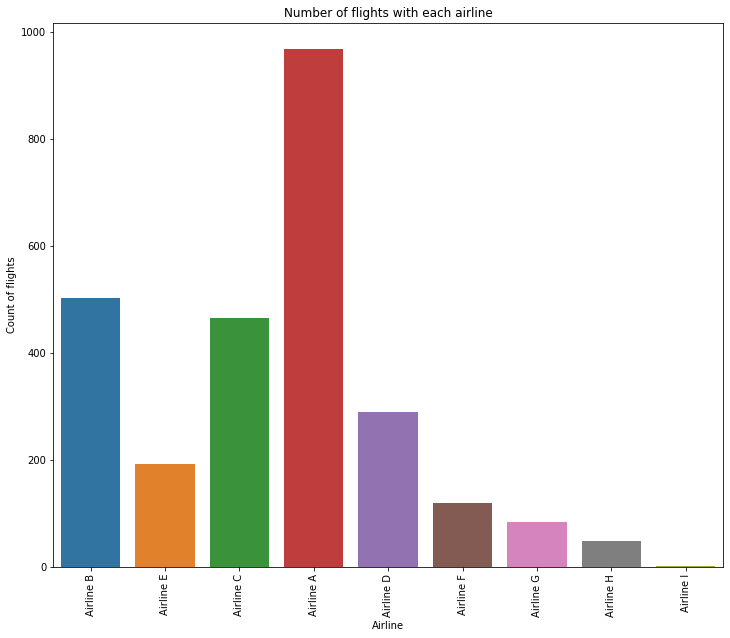

In [5388]:
#Checking similarity with the train data
#Number of flights with each airlne
plt.figure(figsize = (12, 10))
plt.title('Number of flights with each airline')
ax=sns.countplot(x = dft['Airline'])
plt.xlabel('Airline')
plt.ylabel('Count of flights')
plt.xticks(rotation = 90)
plt.show()

**A > B > C > D > E > F > G > H > I || The distribution is  similar to the train dataset**

In [5389]:
#Renaming columns for ease of use
dft.rename(columns = {'Additional_Info':'Info', 'Date_of_Journey': 'Start_Date'}, inplace = True)

In [5390]:
df.Info.value_counts()

No info                         6260
In-flight meal not included     1492
No check-in baggage included     249
Name: Info, dtype: int64

In [5391]:
#Replacing long string values with numbers for ease of use
def stops(x):
    if(x=='non-stop'):
        x=str(0)
    else:
        x.strip()
        stps=x.split(' ')[0]
        x=stps
    return x
dft['Total_Stops']=dft['Total_Stops'].apply(stops)

In [5392]:
#Converting hours into minutes
dft['Duration'] = dft['Duration'].str.replace("h", '*60').str.replace(' ','+').str.replace('m','*1').apply(eval)

In [5393]:
dft.columns

Index(['Airline', 'Start_Date', 'Source', 'Destination', 'Route', 'Dep_Time',
       'Arrival_Time', 'Duration', 'Total_Stops', 'Info'],
      dtype='object')

In [5394]:
#Departure
dft["Dep_hour"] = pd.to_datetime(dft["Dep_Time"]).dt.hour
dft["Dep_min"] = pd.to_datetime(dft["Dep_Time"]).dt.minute
dft.drop(["Dep_Time"], axis = 1, inplace = True)
#Arrival
dft["Arrival_hour"] = pd.to_datetime(dft.Arrival_Time).dt.hour
dft["Arrival_min"] = pd.to_datetime(dft.Arrival_Time).dt.minute
dft.drop(["Arrival_Time"], axis = 1, inplace = True)

In [5395]:
dft["Journey_month"] = dft.Start_Date.dt.month
dft['Dep_Date'] = dft.Start_Date.dt.day
dft.drop('Start_Date', axis = 1, inplace = True)

In [5396]:
dft["Info"].replace({'Change airports': 'No info', '1 Long layover': 'No info', 'Business class': 'No info' }, inplace=True)

In [5397]:
#Route Column
dft['Airport_1'] = dft['Route'].str.split('→').str[0]
dft['Airport_2'] = dft['Route'].str.split('→').str[1]
dft['Airport_3'] = dft['Route'].str.split('→').str[2]
dft['Airport_4'] = dft['Route'].str.split('→').str[3]
dft['Airport_5'] = dft['Route'].str.split('→').str[4]

dft['Airport_1'].fillna('None', inplace = True)
dft['Airport_2'].fillna('None', inplace = True)
dft['Airport_3'].fillna('None', inplace = True)
dft['Airport_4'].fillna('None', inplace = True)
dft['Airport_5'].fillna('None', inplace = True)
dft.drop('Route', axis = 1, inplace = True)

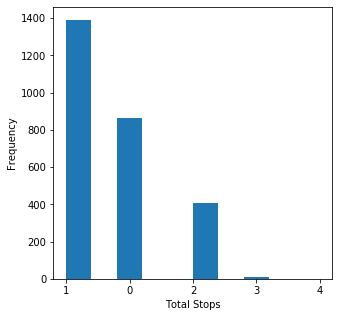

In [5398]:
#Frequency of flight as per months
plt.figure(figsize = (5,5))
plt.hist(dft.Total_Stops)
plt.xlabel('Total Stops')
plt.ylabel('Frequency')
plt.show()

**Since the frequency of flights that stop at 4 places is highly negligible, we can drop the rows with **

# One-hot encoding

In [5399]:
#For Airline
airline_tdummies = pd.get_dummies(dft.Airline)
#merging the dummies with the dataframe
mergedt = pd.concat([dft,airline_tdummies], axis = 'columns')
#dropping Airline column and a dummy variable to avoid the dummy variable trap
mergedt.drop(['Airline', 'Airline I'], axis = 'columns', inplace = True)
mergedt

,Source,Destination,Duration,Total_Stops,Info,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Journey_month,...,Airport_4,Airport_5,Airline A,Airline B,Airline C,Airline D,Airline E,Airline F,Airline G,Airline H
0,Delhi,Cochin,675,1,No info,4,55,16,10,3,...,None,None,0,1,0,0,0,0,0,0
1,Kolkata,Banglore,140,0,No info,22,20,0,40,5,...,None,None,0,0,0,0,1,0,0,0
2,Kolkata,Banglore,875,2,No info,5,50,20,25,6,...,BLR,None,0,0,1,0,0,0,0,0
3,Banglore,New Delhi,280,1,No info,9,45,14,25,3,...,None,None,1,0,0,0,0,0,0,0
4,Delhi,Cochin,570,1,No info,16,0,1,30,6,...,None,None,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,Delhi,Cochin,675,1,No info,8,0,19,15,3,...,None,None,0,0,1,0,0,0,0,0
2667,Kolkata,Banglore,150,0,No info,19,55,22,25,4,...,None,None,0,0,0,0,0,0,1,0
2668,Delhi,Cochin,425,2,In-flight meal not included,5,30,12,35,6,...,COK,None,1,0,0,0,0,0,0,0
2669,Banglore,Delhi,180,0,In-flight meal not included,8,20,11,20,5,...,None,None,1,0,0,0,0,0,0,0


In [5400]:
#For Source
source_dummiest = pd.get_dummies(dft.Source)
#merging the dummies with the dataframe
mergedt = pd.concat([mergedt,source_dummiest], axis = 'columns')
#dropping Source column and a dummy variable to avoid the dummy variable trap
mergedt.drop(['Source', 'Banglore'], axis = 'columns', inplace = True)

In [5401]:
mergedt.rename(columns = {'Chennai':'Chennai_Source', 'Delhi': 'Delhi_Source', 'Kolkata': 'Kolkata_Source', 'Mumbai': 'Mumbai_Source'}, inplace = True)

In [5402]:
#For Destination
dest_dummiest = pd.get_dummies(dft.Destination)
#merging the dummies with the dataframe
mergedt = pd.concat([mergedt,dest_dummiest], axis = 'columns')
#dropping Destination column and a dummy variable to avoid the dummy variable trap
mergedt.drop(['Destination', 'Delhi'], axis = 'columns', inplace = True)
mergedt.head(2)

,Duration,Total_Stops,Info,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Journey_month,Dep_Date,Airport_1,...,Airline H,Chennai_Source,Delhi_Source,Kolkata_Source,Mumbai_Source,Banglore,Cochin,Hyderabad,Kolkata,New Delhi
0,675,1,No info,4,55,16,10,3,27,DEL,...,0,0,1,0,0,0,1,0,0,0
1,140,0,No info,22,20,0,40,5,27,CCU,...,0,0,0,1,0,1,0,0,0,0


In [5403]:
#LabelEncoding the Total_Stops columns
lbt_test = LabelEncoder()
mergedt['Total_Stops'] = lbt_test.fit_transform(mergedt['Total_Stops'])
mergedt.head(10)

,Duration,Total_Stops,Info,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Journey_month,Dep_Date,Airport_1,...,Airline H,Chennai_Source,Delhi_Source,Kolkata_Source,Mumbai_Source,Banglore,Cochin,Hyderabad,Kolkata,New Delhi
0,675,1,No info,4,55,16,10,3,27,DEL,...,0,0,1,0,0,0,1,0,0,0
1,140,0,No info,22,20,0,40,5,27,CCU,...,0,0,0,1,0,1,0,0,0,0
2,875,2,No info,5,50,20,25,6,6,CCU,...,0,0,0,1,0,1,0,0,0,0
3,280,1,No info,9,45,14,25,3,6,BLR,...,0,0,0,0,0,0,0,0,0,1
4,570,1,No info,16,0,1,30,6,15,DEL,...,0,0,1,0,0,0,1,0,0,0
5,1215,1,In-flight meal not included,8,25,4,40,5,9,CCU,...,0,0,0,1,0,1,0,0,0,0
6,810,1,No info,7,30,21,0,6,24,DEL,...,0,0,1,0,0,0,1,0,0,0
7,490,1,No info,4,45,12,55,3,9,DEL,...,0,0,1,0,0,0,1,0,0,0
8,1130,2,No info,9,35,4,25,6,24,DEL,...,0,0,1,0,0,0,1,0,0,0
9,90,0,In-flight meal not included,10,20,11,50,4,1,BOM,...,0,0,0,0,1,0,0,1,0,0


In [5404]:
#For Info
info_dummiest = pd.get_dummies(dft.Info)
#merging the dummies with the dataframe
mergedt = pd.concat([mergedt,info_dummiest], axis = 'columns')
#dropping Total_Stops column and a dummy variable to avoid the dummy variable trap
mergedt.drop(['Info', 'No check-in baggage included'], axis = 'columns', inplace = True)
mergedt.head(2)

,Duration,Total_Stops,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Journey_month,Dep_Date,Airport_1,Airport_2,...,Delhi_Source,Kolkata_Source,Mumbai_Source,Banglore,Cochin,Hyderabad,Kolkata,New Delhi,In-flight meal not included,No info
0,675,1,4,55,16,10,3,27,DEL,HYD,...,1,0,0,0,1,0,0,0,0,1
1,140,0,22,20,0,40,5,27,CCU,BLR,...,0,1,0,1,0,0,0,0,0,1


In [5405]:
#LabelEncoding the Airport columns
lbe_test = LabelEncoder()
mergedt['Airport_1'] = lbe_test.fit_transform(mergedt['Airport_1'])
mergedt['Airport_2'] = lbe_test.fit_transform(mergedt['Airport_2'])
mergedt['Airport_3'] = lbe_test.fit_transform(mergedt['Airport_3'])
mergedt['Airport_4'] = lbe_test.fit_transform(mergedt['Airport_4'])
mergedt['Airport_5'] = lbe_test.fit_transform(mergedt['Airport_5'])
mergedt.head(3)

,Duration,Total_Stops,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Journey_month,Dep_Date,Airport_1,Airport_2,...,Delhi_Source,Kolkata_Source,Mumbai_Source,Banglore,Cochin,Hyderabad,Kolkata,New Delhi,In-flight meal not included,No info
0,675,1,4,55,16,10,3,27,3,18,...,1,0,0,0,1,0,0,0,0,1
1,140,0,22,20,0,40,5,27,2,5,...,0,1,0,1,0,0,0,0,0,1
2,875,2,5,50,20,25,6,6,2,22,...,0,1,0,1,0,0,0,0,0,1


In [5406]:
dff_test = mergedt.copy()
dff_test.columns

Index(['Duration', 'Total_Stops', 'Dep_hour', 'Dep_min', 'Arrival_hour',
       'Arrival_min', 'Journey_month', 'Dep_Date', 'Airport_1', 'Airport_2',
       'Airport_3', 'Airport_4', 'Airport_5', 'Airline A', 'Airline B',
       'Airline C', 'Airline D', 'Airline E', 'Airline F', 'Airline G',
       'Airline H', 'Chennai_Source', 'Delhi_Source', 'Kolkata_Source',
       'Mumbai_Source', 'Banglore', 'Cochin', 'Hyderabad', 'Kolkata',
       'New Delhi', 'In-flight meal not included', 'No info'],
      dtype='object')

In [5407]:
test_y_pred = grid_xgb.predict(dff_test)

In [5408]:
test_y_pred

array([ 6259.969 ,  5751.7227, 11850.939 , ..., 13518.106 ,  6354.4893,
        7231.564 ], dtype=float32)

In [5409]:
submission_file = pd.DataFrame(test_y_pred, columns = ['Price'])

In [5410]:
submission_file.head()

,Price
0,6259.969238
1,5751.722656
2,11850.939453
3,13173.339844
4,7447.969238


In [5411]:
submission_file.to_csv('Manpreet Kaur_Flight Prices3.csv', index = False)